In [22]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pywt
import math
import scipy.stats as st
from matplotlib.colors import LogNorm

In [23]:
def plot_ds_from_h5(filename, mouse_name, time_window=(-0.5,1.5), f_range=(2,40)):
    # Trial types in same order as saved
    trial_type_names = [
        'HC Hit', 'HC Miss',
        'MC Hit', 'MC Miss', 'MC No Report',
        'False Alarm', 'Correct Rejection', 'LC No Report']

    # Load data
    with h5py.File(filename, 'r') as h5f:
        fig, axs = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
        axs = axs.ravel()

        for i, trial_type in enumerate(trial_type_names):
            group = h5f[trial_type]
            wt_plot = group["MeanDynamicSpectrum"][()]
            freqs = group.attrs["Frequencies"]
            time_axis = group.attrs["Time_Array"]
            ds = group["DynamicSpectra"][()]
            
            # Restrict time range
            time_mask = (time_axis >= time_window[0]) & (time_axis <= time_window[1])
            time_axis_cut = time_axis[time_mask]
            wt_plot_cut = wt_plot[:, time_mask]

            # Plotting
            ax = axs[i]
            cs = np.quantile(wt_plot_cut, [0.01, 0.99])
            pcm = ax.pcolormesh(time_axis_cut, freqs, wt_plot_cut, shading='auto', cmap='jet')
            pcm.set_clim(cs[0], cs[1])

            ax.set_title(f'{trial_type} ({len(ds)} Trials)', fontsize=12)
            ax.set_xlabel("Time from Stimulus Onset (s)", fontsize=10)
            ax.set_ylabel("Frequency (Hz)", fontsize=10)
            ax.set_ylim(f_range)

            # Add individual colorbar to each subplot
            cbar = fig.colorbar(pcm, ax=ax)
            cbar.ax.set_ylabel("% Increase in Power", rotation=270, labelpad=10)

        fig.suptitle(f"Mean Dynamic Spectra for {mouse_name} (Individually Quantile Normalized)", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.99])  # Leave space for title
        plt.show()

def quantiles(filename):
    trial_type_names = [
        'HC Hit', 'HC Miss',
        'MC Hit', 'MC Miss', 'MC No Report',
        'False Alarm', 'Correct Rejection', 'LC No Report']

    all_ds = []

    with h5py.File(filename, 'r') as h5f:
        for trial_type in trial_type_names:
            if trial_type in h5f:
                group = h5f[trial_type]
                ds = group["DynamicSpectra"][()]  # shape: (n_trials, n_freqs, n_timepoints)
                ds_cropped = ds[:, :, int(157*0.1):int(157*4.9)]      # remove first and last 0.1s
                all_ds.append(ds_cropped)

    # Concatenate across all trial types along the trial axis
    combined_ds = np.concatenate(all_ds, axis=0)  # shape: (total_trials, n_freqs, n_timepoints)

    # Compute mean power across trials
    mean_power = np.nanmean(combined_ds, axis=0)  # shape: (n_freqs, n_timepoints)

    # Compute 1st and 10th quantile across time for each frequency
    q01 = np.quantile(mean_power, 0.01, axis=1, keepdims=True)  # shape: (n_freqs, 1)
    q10 = np.quantile(mean_power, 0.10, axis=1, keepdims=True)  # shape: (n_freqs, 1)
    
    return q01, q10

def plot_ds_global_norm(filename, mouse_name, time_window=(-0.5,1.5), f_range=(2,40)):
    trial_type_names = [
            'HC Hit', 'HC Miss',
            'MC Hit', 'MC Miss', 'MC No Report',
            'False Alarm', 'Correct Rejection', 'LC No Report']

    # Linear-scaled plot
    fig, axs = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
    axs = axs.ravel()

    q01, q10 = quantiles(filename)

    for i, trial_type in enumerate(trial_type_names):
        all_power1 = []
        with h5py.File(filename, 'r') as h5f:
            group = h5f[trial_type]
            ds = group["DynamicSpectra"][()].squeeze()
            freqs = group.attrs["Frequencies"]
            time_axis = group.attrs["Time_Array"]

            # Time window masking
            time_mask = (time_axis >= time_window[0]) & (time_axis <= time_window[1])
            time_axis_cut = time_axis[time_mask]

        mean_power = np.mean(ds[:,:,time_mask], axis=0)

        mean_power = ((mean_power - q01) / (q10 + 1e-10))*100

        ax = axs[i]
        pcm = ax.pcolormesh(time_axis_cut, freqs, mean_power, shading='auto', cmap='jet')

        ax.set_title(f'{trial_type} ({len(ds)} Trials)', fontsize=12)
        ax.set_xlabel("Time from Stimulus Onset (s)", fontsize=10)
        ax.set_ylabel("Frequency (Hz)", fontsize=10)
        ax.set_ylim(f_range)

        cbar = fig.colorbar(pcm, ax=ax)
        cbar.ax.set_ylabel("% Change in Power", rotation=270, labelpad=10)

    fig.suptitle(f"Mean Dynamic Spectra for {mouse_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

def plot_shared_colorbar(filename, mouse_name, time_window=(-0.5,1.5), f_range=(2,40), low_p=5, high_p=99):
    trial_type_names = [
        'HC Hit', 'HC Miss',
        'MC Hit', 'MC Miss', 'MC No Report',
        'False Alarm', 'Correct Rejection', 'LC No Report'
    ]

    # Compute normalization quantiles
    q01, q10 = quantiles(filename)

    # Store results for plotting
    mean_powers = {}
    all_vals = []  # collect all values for global percentile range

    with h5py.File(filename, 'r') as h5f:
        for trial_type in trial_type_names:
            group = h5f[trial_type]
            ds = group["DynamicSpectra"][()].squeeze()
            freqs = group.attrs["Frequencies"]
            time_axis = group.attrs["Time_Array"]

            # Time window masking
            time_mask = (time_axis >= time_window[0]) & (time_axis <= time_window[1])
            time_axis_cut = time_axis[time_mask]

            # Mean power across trials
            mean_power = np.mean(ds[:, :, time_mask], axis=0)

            # Global quantile normalization
            mean_power = ((mean_power - q01) / (q10 + 1e-10)) * 100

            mean_powers[trial_type] = (time_axis_cut, freqs, mean_power, len(ds))

            # Collect values for percentile scaling
            all_vals.append(mean_power.flatten())

    # Compute 1st–95th global percentiles
    all_vals = np.concatenate(all_vals)
    vmin = np.nanpercentile(all_vals, low_p)
    vmax = np.nanpercentile(all_vals, high_p)

    # Plotting
    fig, axs = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
    axs = axs.ravel()

    for i, trial_type in enumerate(trial_type_names):
        time_axis_cut, freqs, mean_power, ntrials = mean_powers[trial_type]

        pcm = axs[i].pcolormesh(time_axis_cut, freqs, mean_power,
                                shading='auto', cmap='jet',
                                vmin=vmin, vmax=vmax)

        axs[i].set_title(f'{trial_type} ({ntrials} Trials)', fontsize=12)
        axs[i].set_xlabel("Time from Stimulus Onset (s)", fontsize=10)
        axs[i].set_ylabel("Frequency (Hz)", fontsize=10)
        axs[i].set_ylim(f_range)

    # Shared colorbar
    cbar = fig.colorbar(pcm, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.ax.set_ylabel("% Change in Power", rotation=270, labelpad=10)

    fig.suptitle(f"Mean Dynamic Spectra for {mouse_name} (Shared Colorbar)", fontsize=16)
    plt.show()

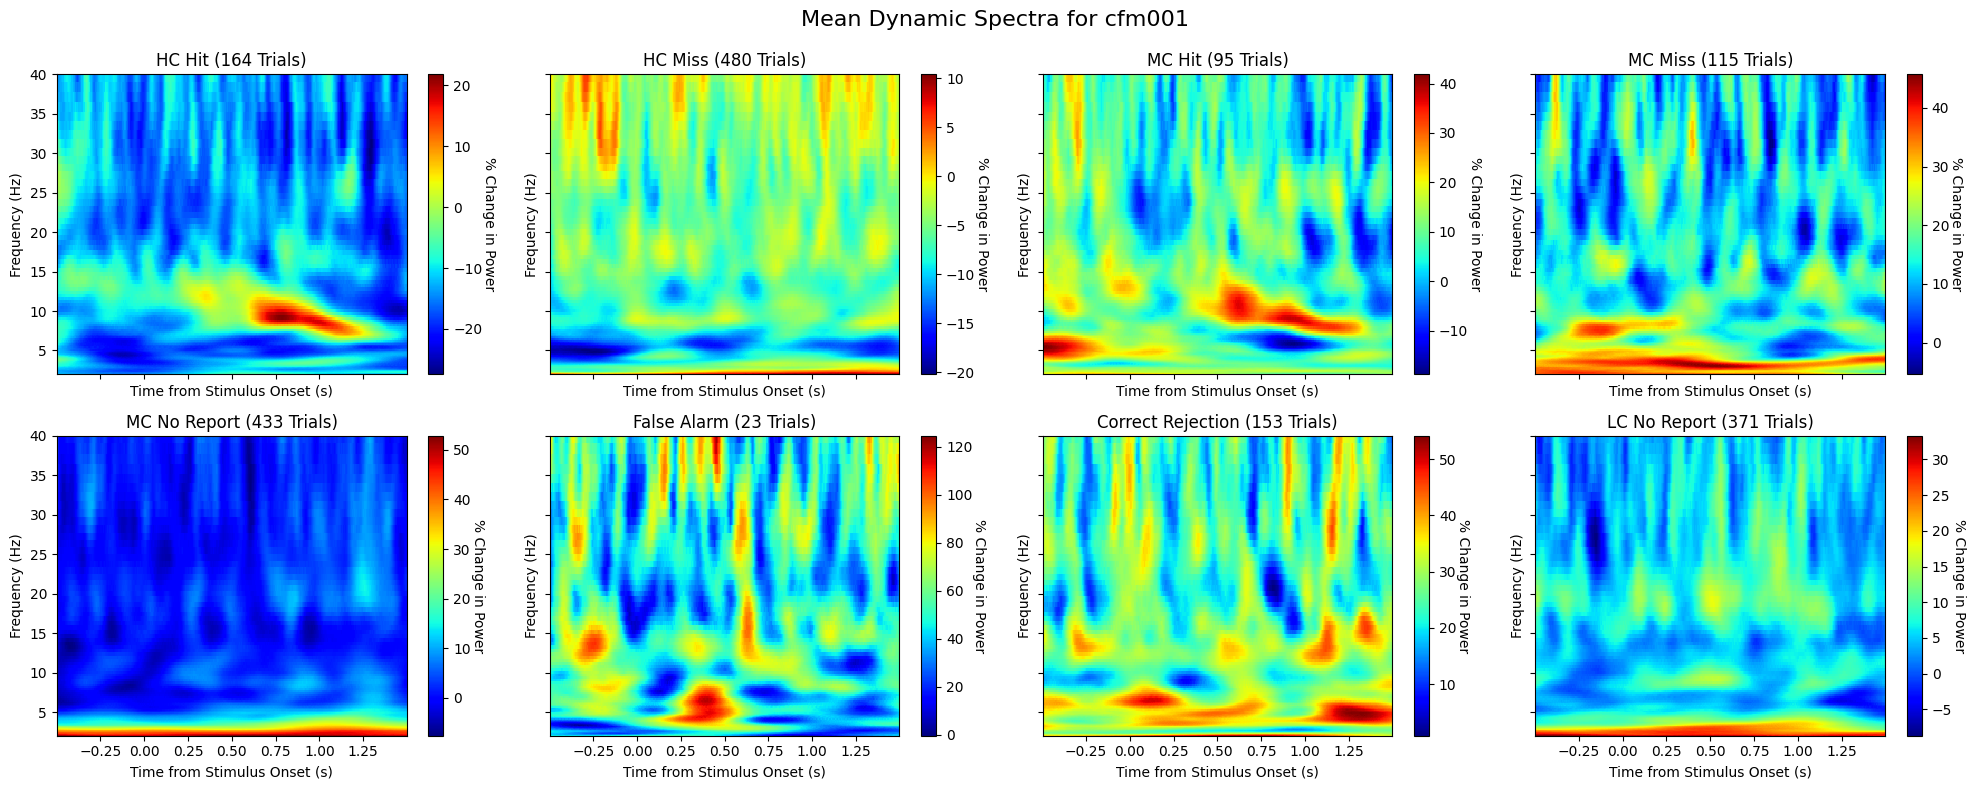

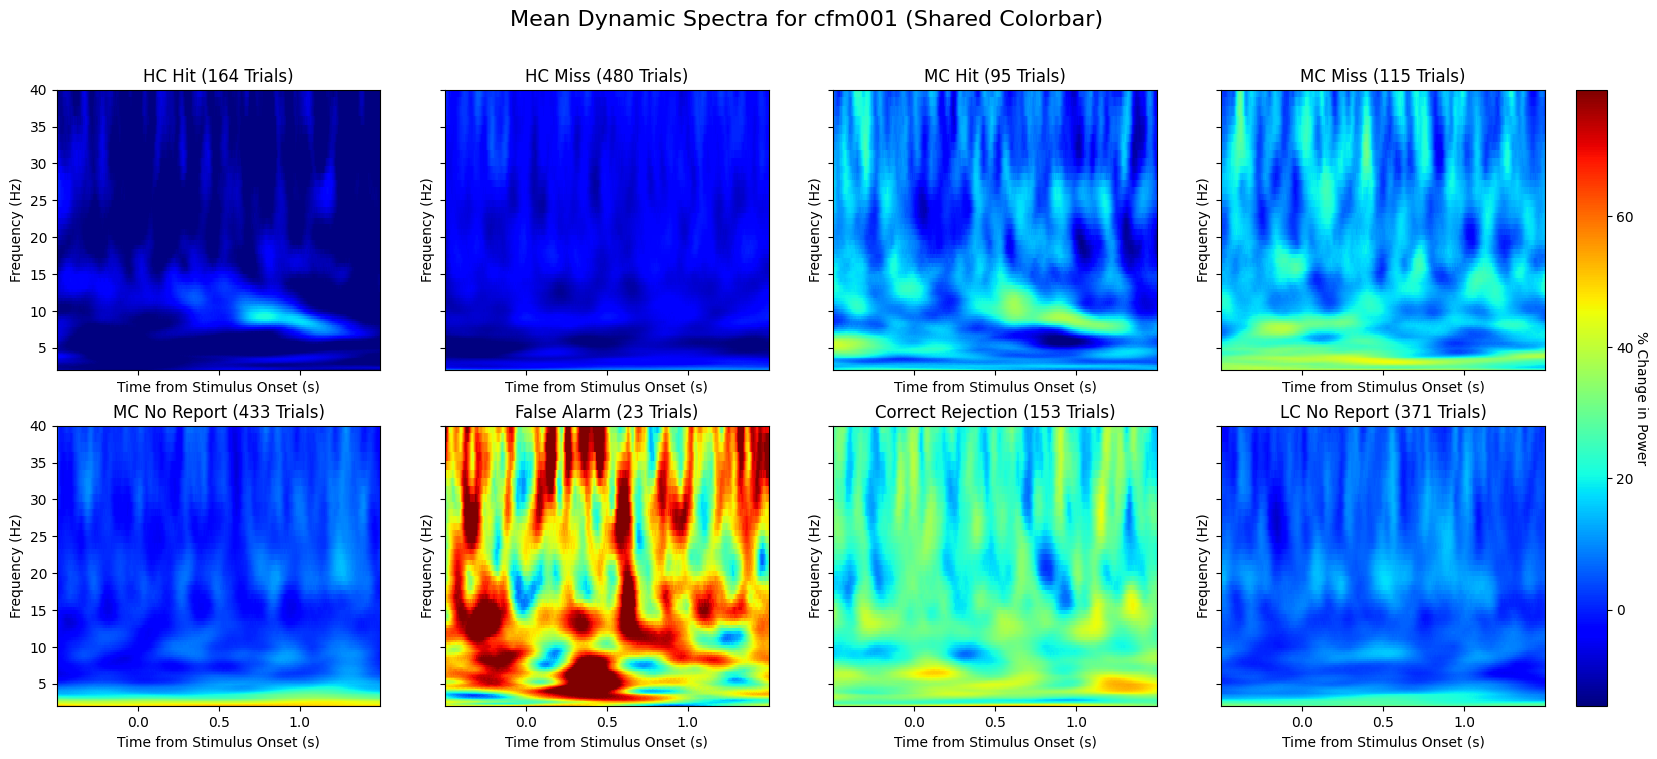

In [24]:
mouse_name = 'cfm001'
filename = f'results/{mouse_name}_dynamic_spec_denoised.h5'

plot_ds_global_norm(filename, mouse_name)
plot_shared_colorbar(filename, mouse_name)

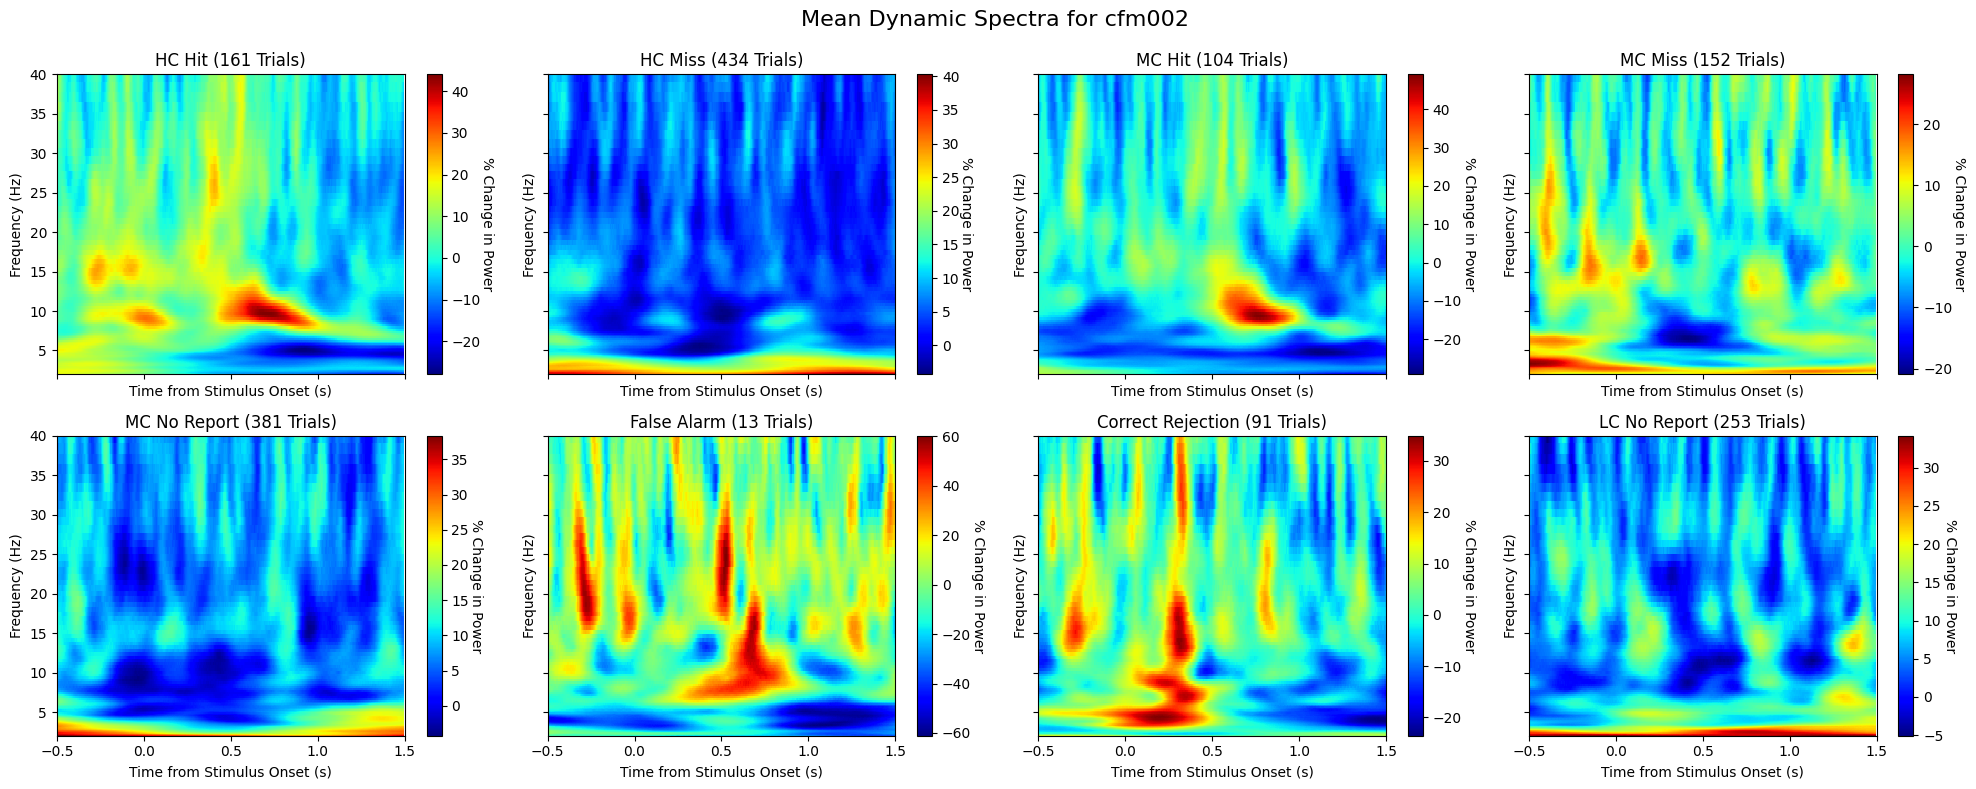

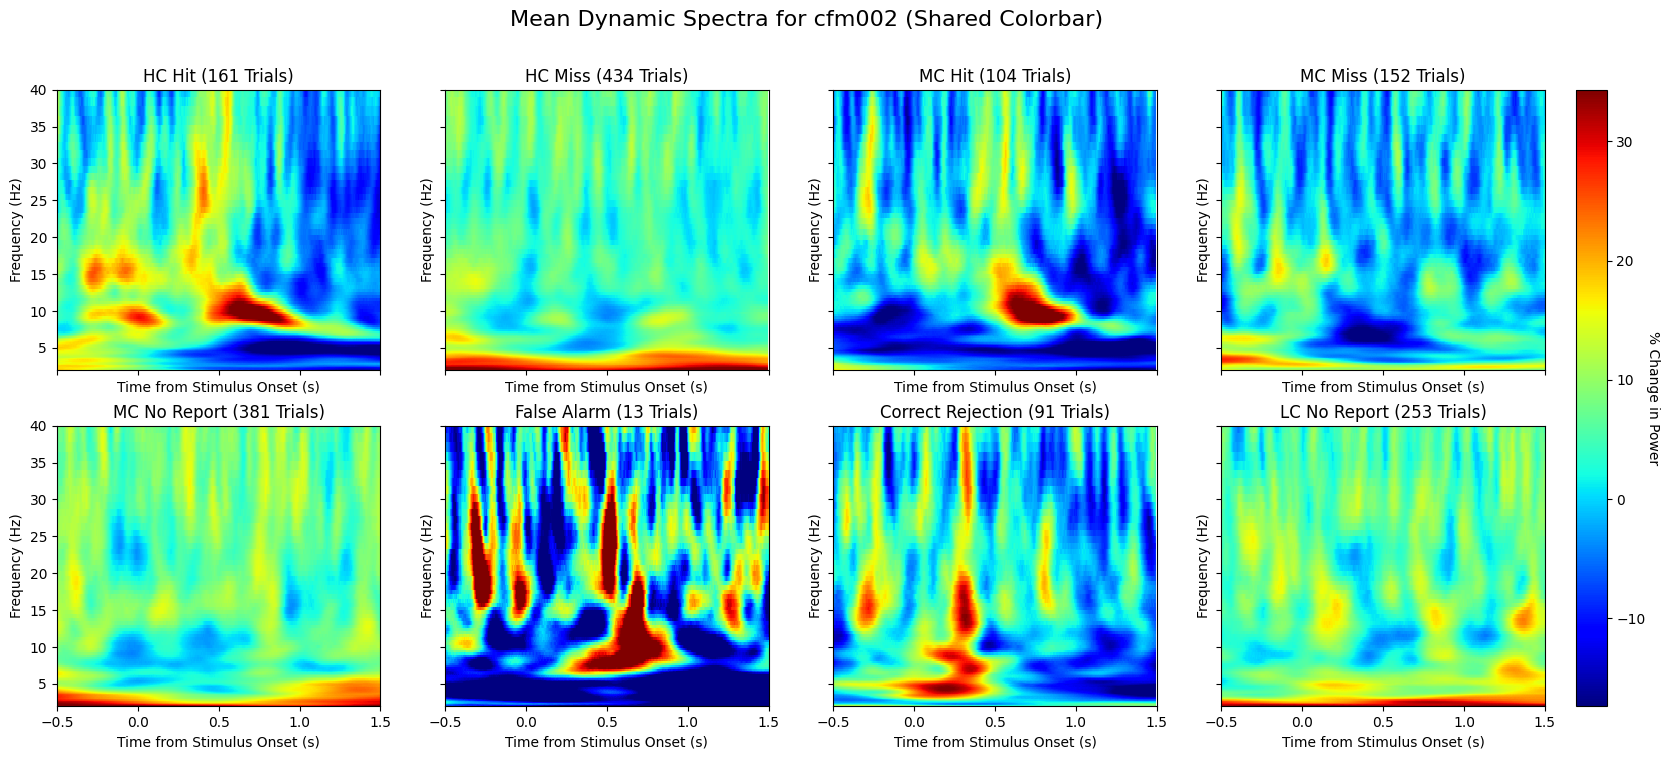

In [25]:
mouse_name = 'cfm002'
filename = f'results/{mouse_name}_dynamic_spec_denoised.h5'

plot_ds_global_norm(filename, mouse_name)
plot_shared_colorbar(filename, mouse_name)

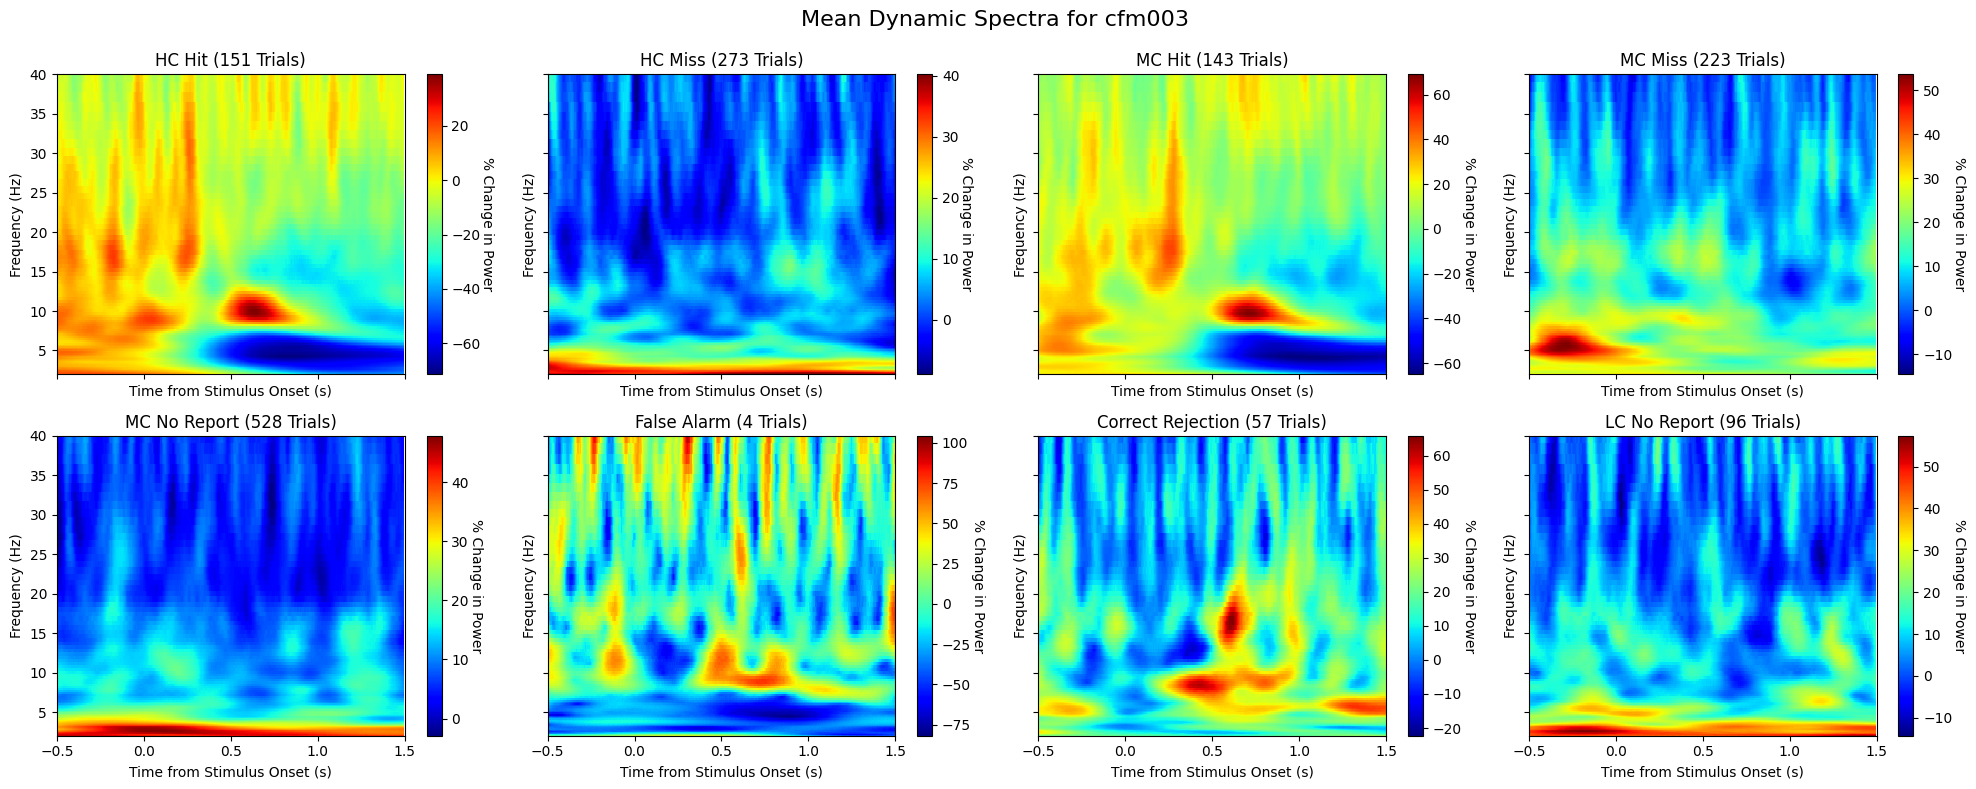

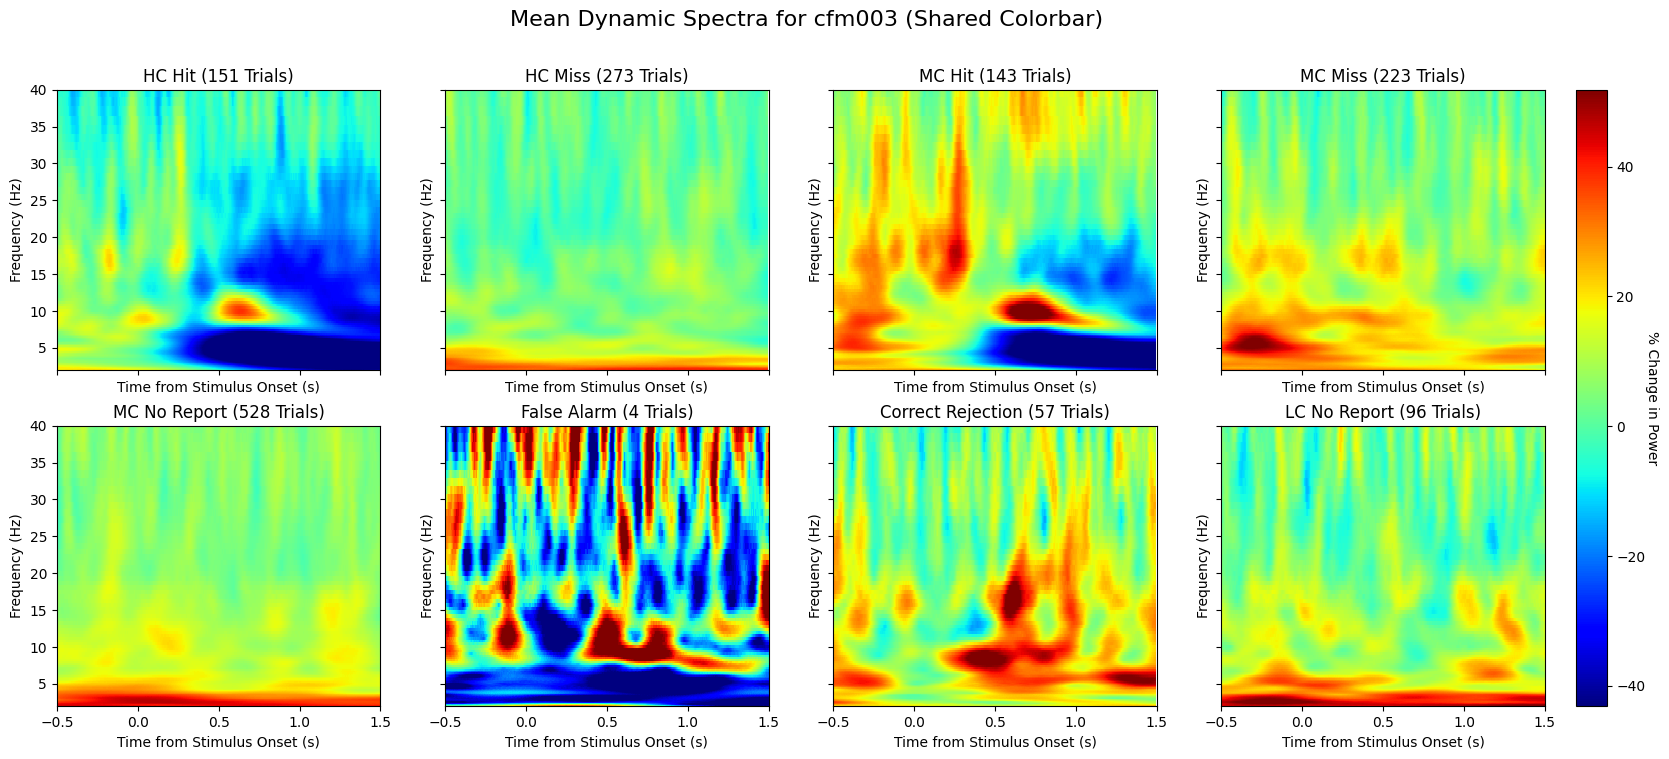

In [26]:
mouse_name = 'cfm003'
filename = f'results/{mouse_name}_dynamic_spec_denoised.h5'

plot_ds_global_norm(filename, mouse_name)
plot_shared_colorbar(filename, mouse_name)

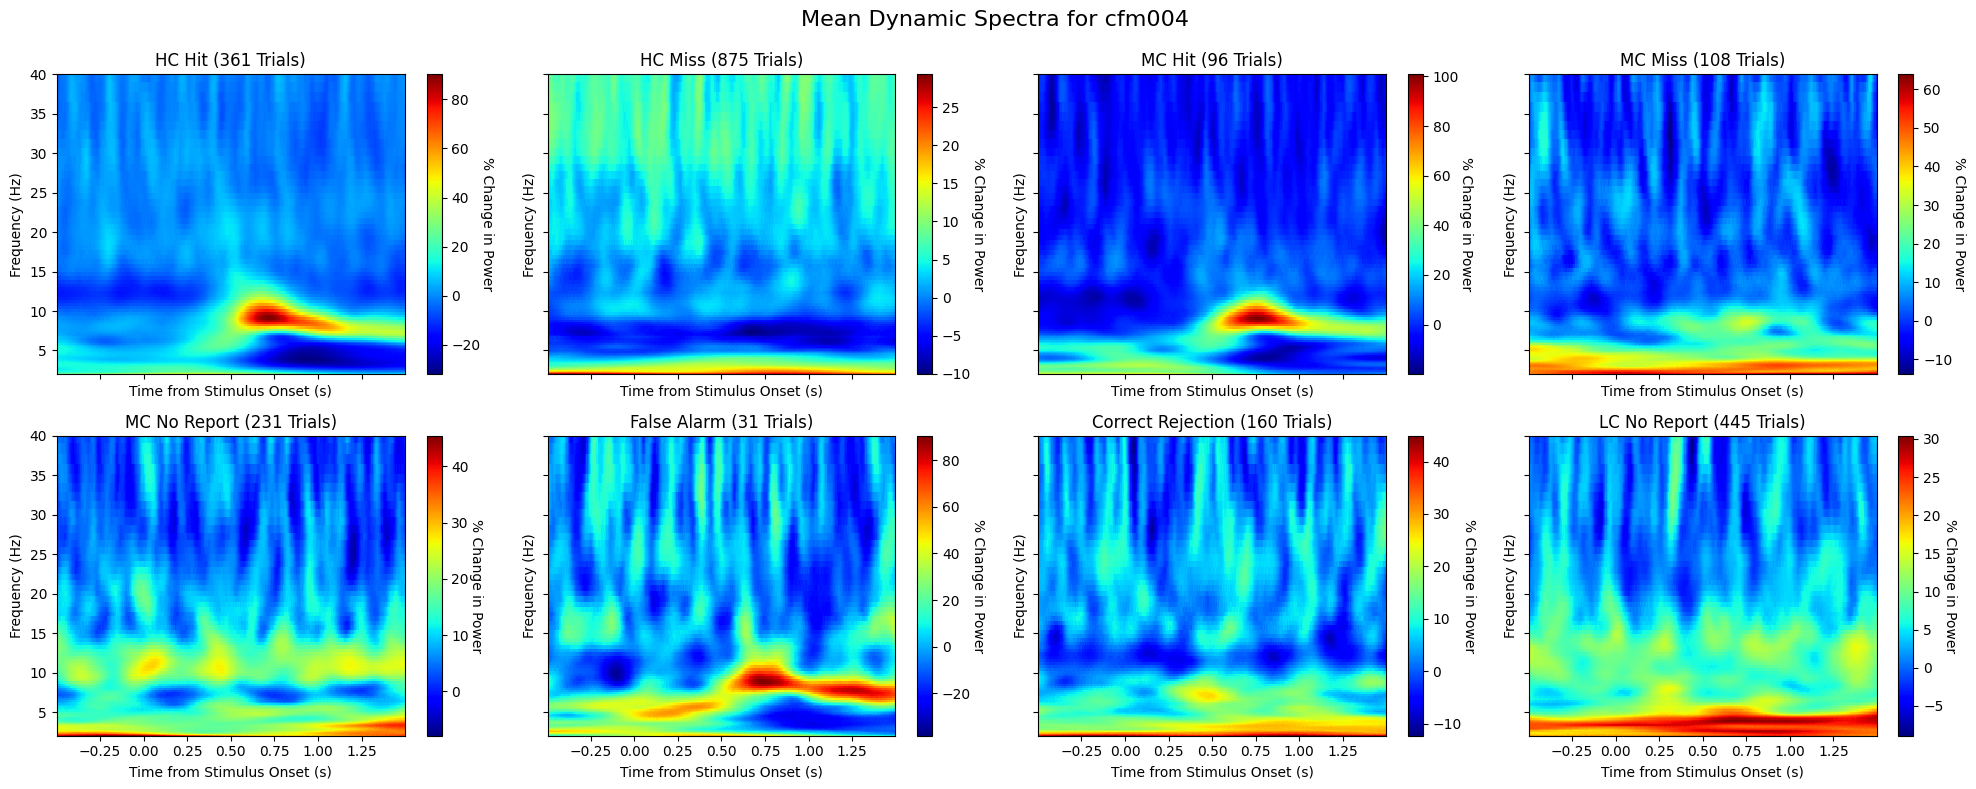

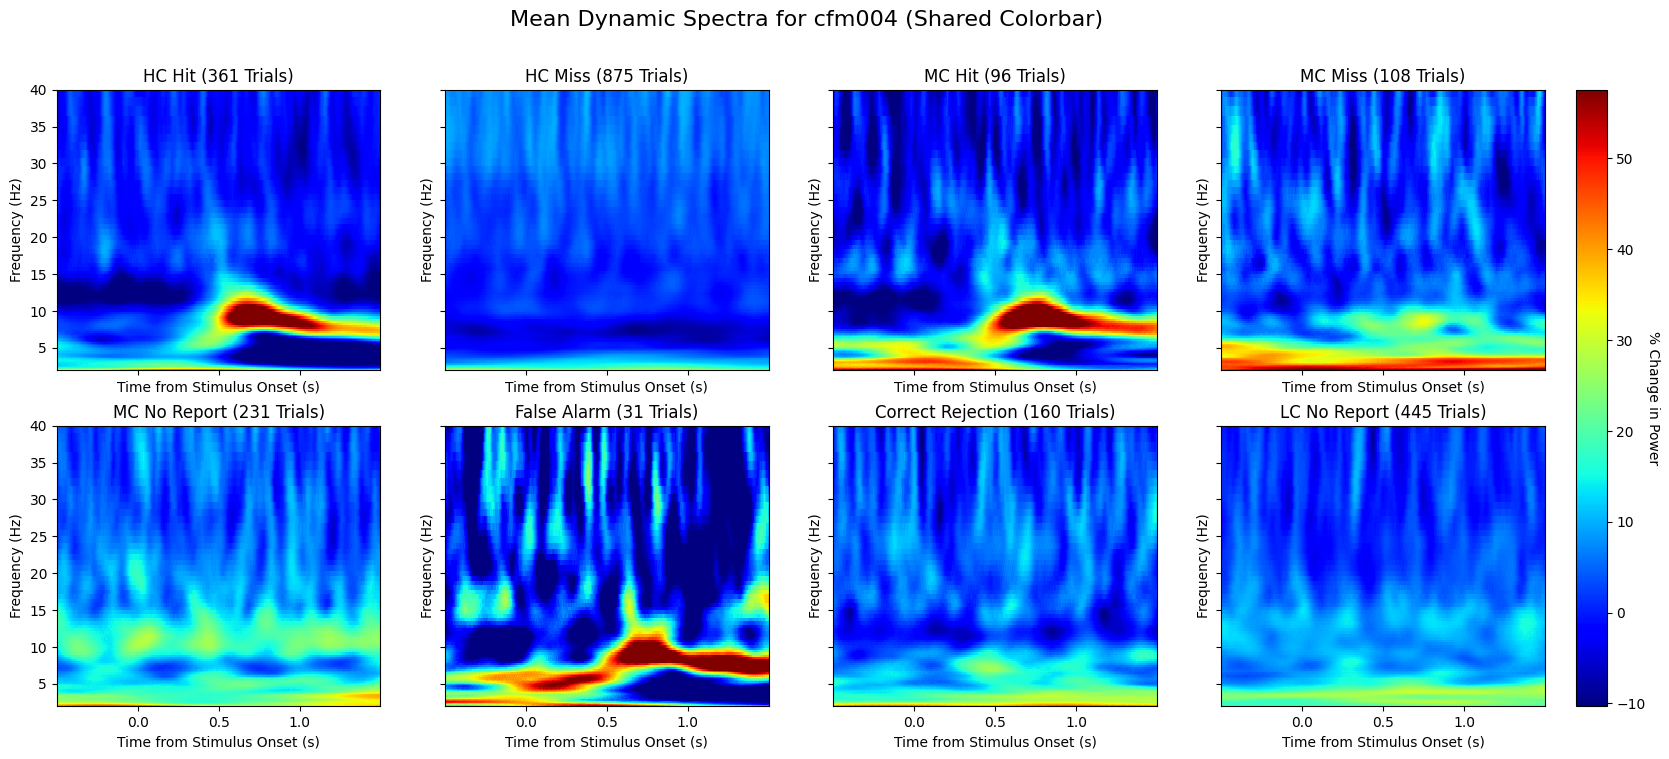

In [27]:
mouse_name = 'cfm004'
filename = f'results/{mouse_name}_dynamic_spec_denoised.h5'

plot_ds_global_norm(filename, mouse_name)
plot_shared_colorbar(filename, mouse_name)

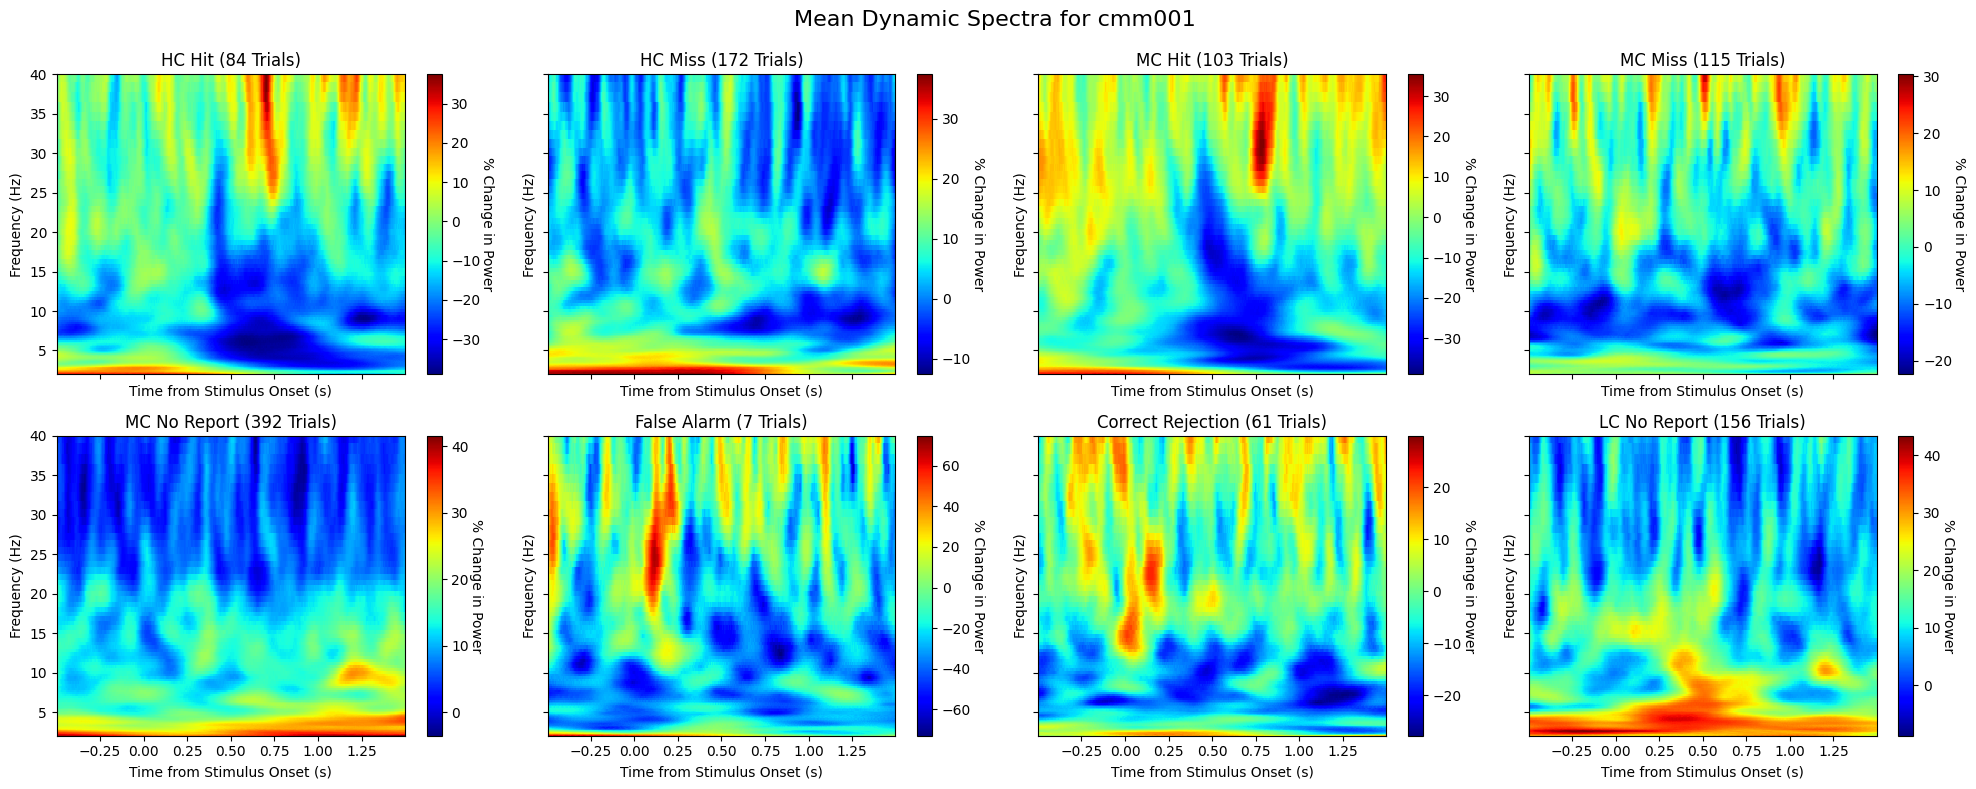

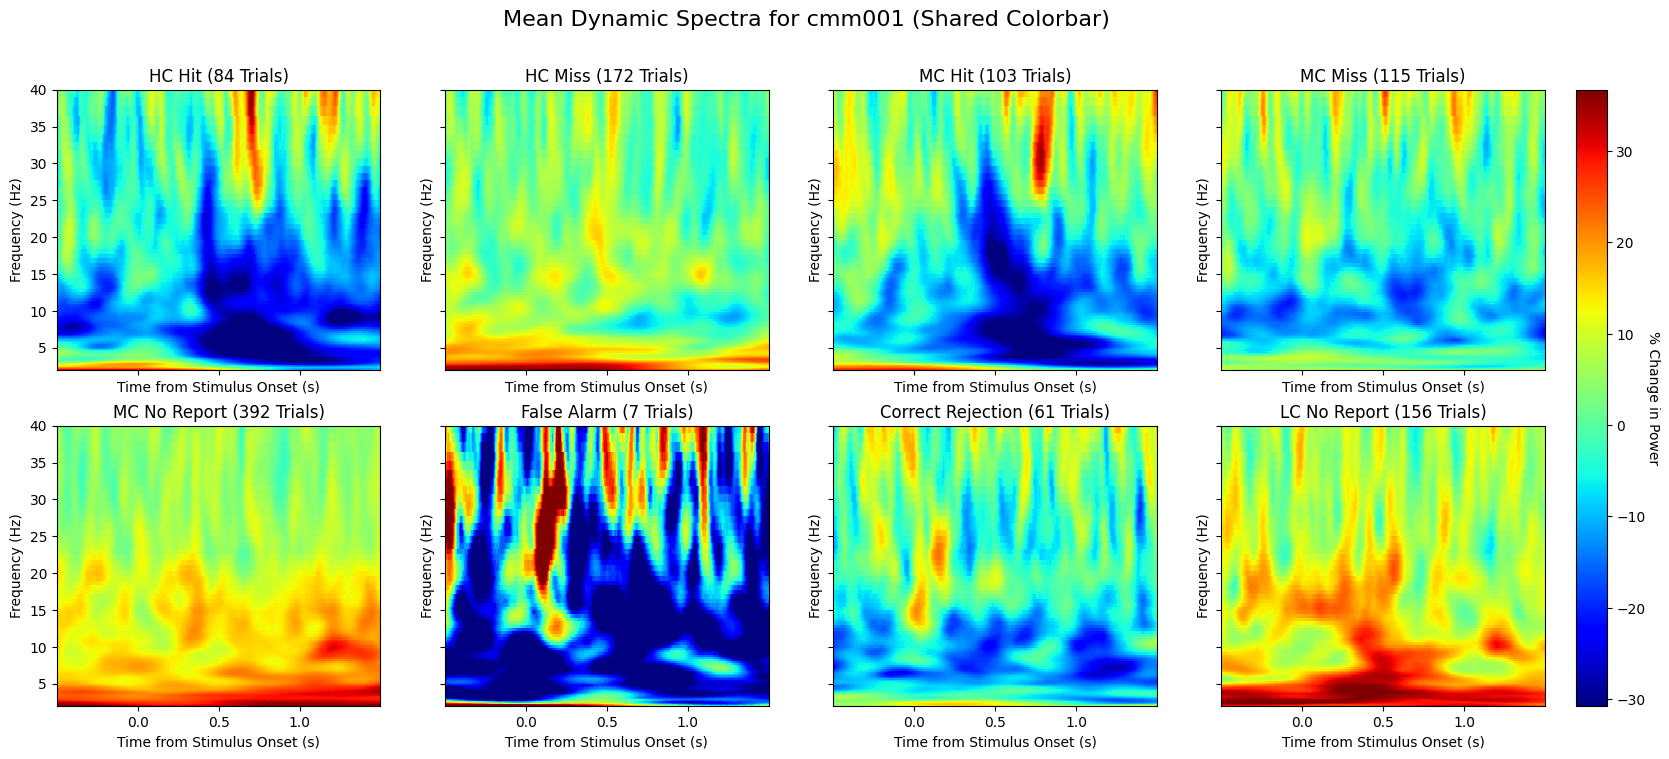

In [28]:
mouse_name = 'cmm001'
filename = f'results/{mouse_name}_dynamic_spec_denoised.h5'

plot_ds_global_norm(filename, mouse_name)
plot_shared_colorbar(filename, mouse_name)

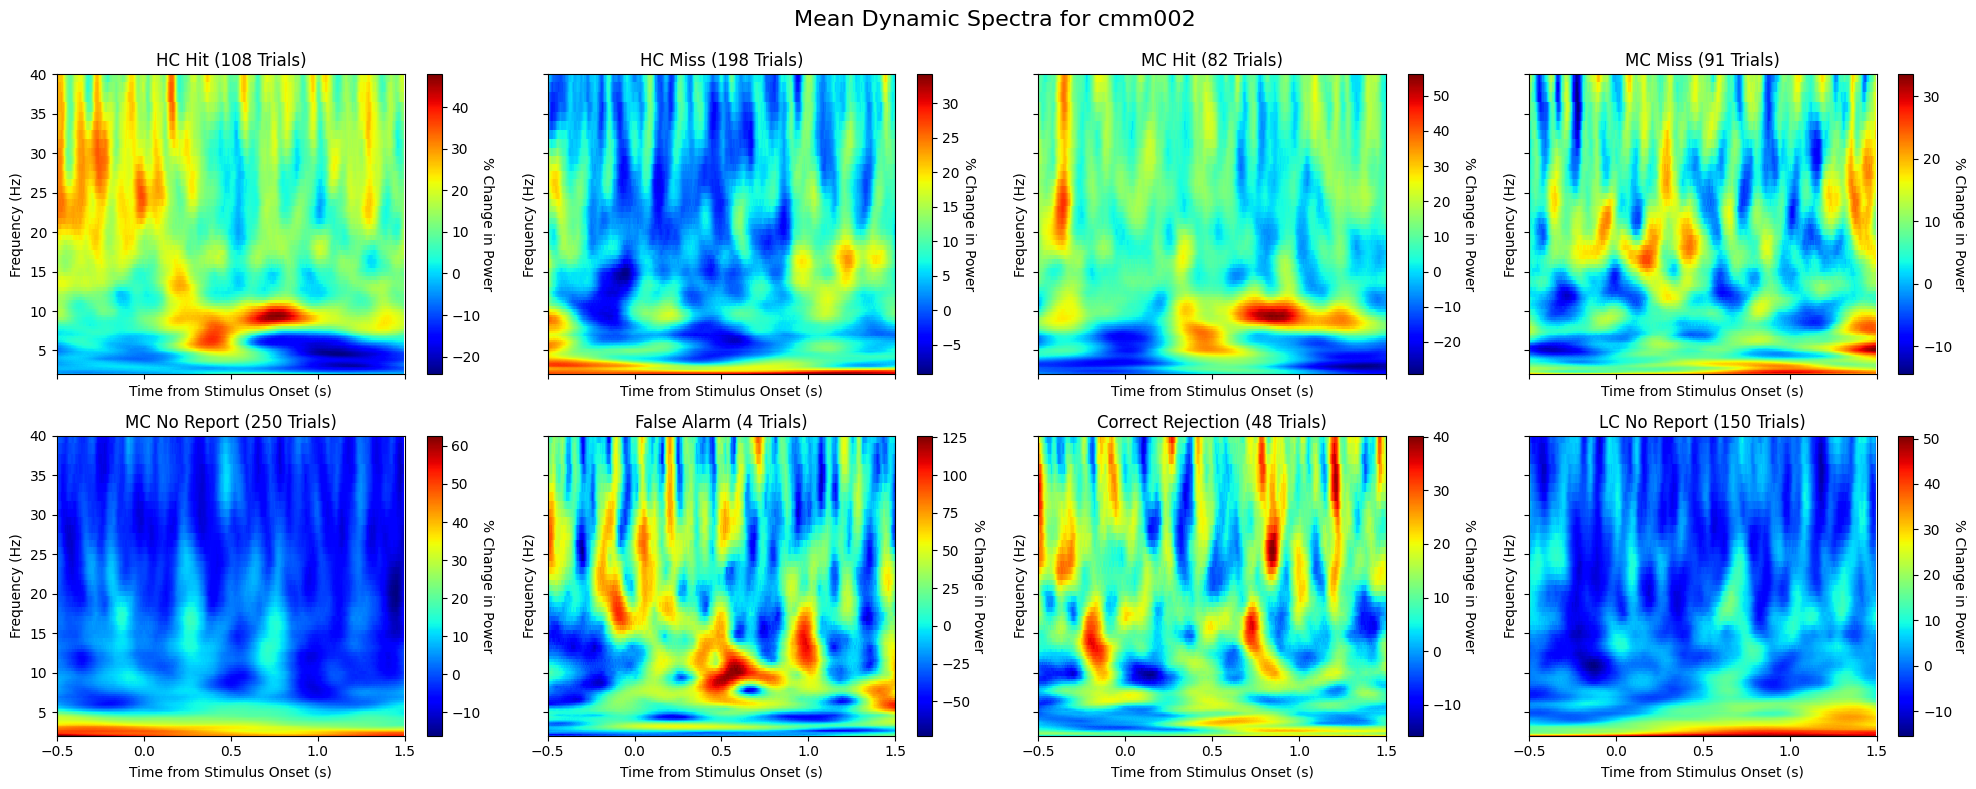

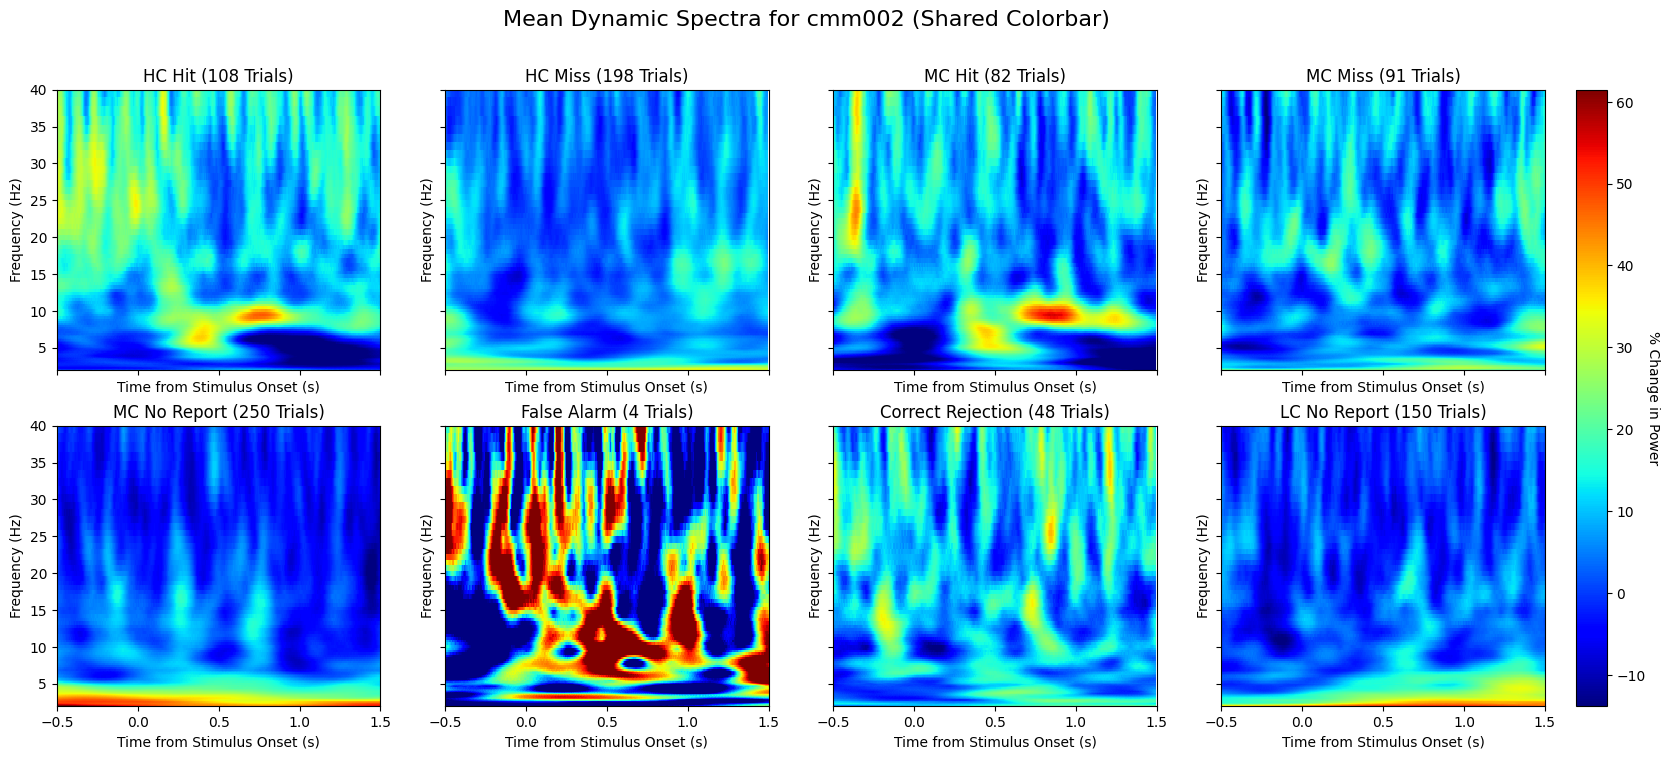

In [29]:
mouse_name = 'cmm002'
filename = "results/cmm002_dynamic_spec_denoised.h5"

plot_ds_global_norm(filename, mouse_name)
plot_shared_colorbar(filename, mouse_name)

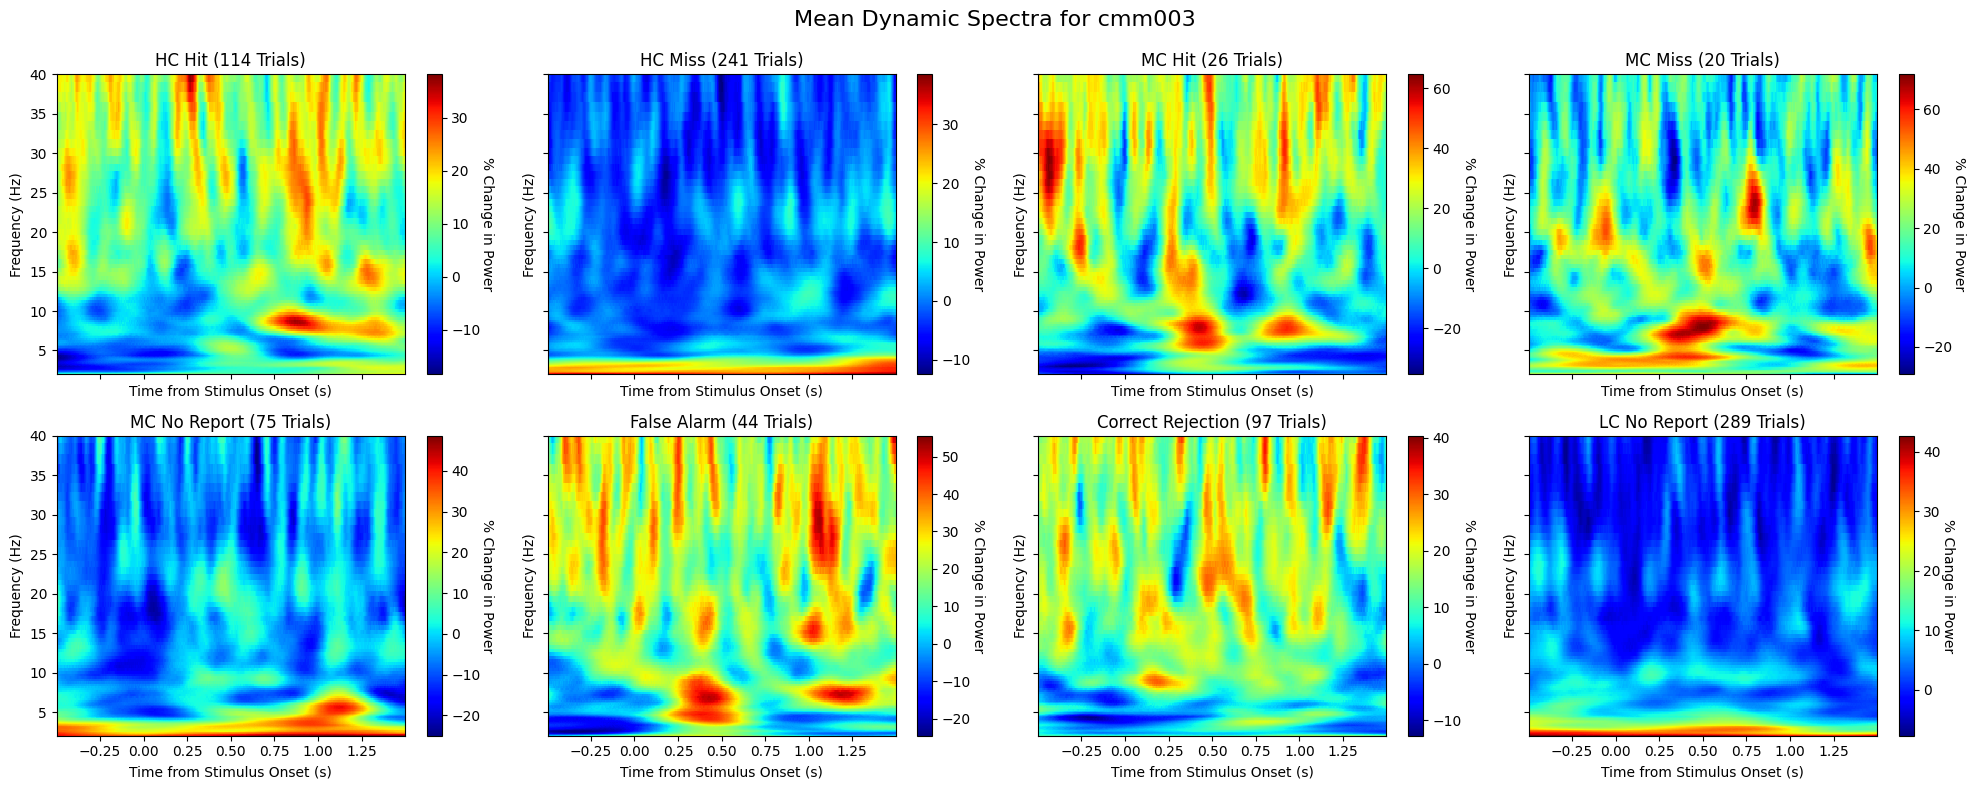

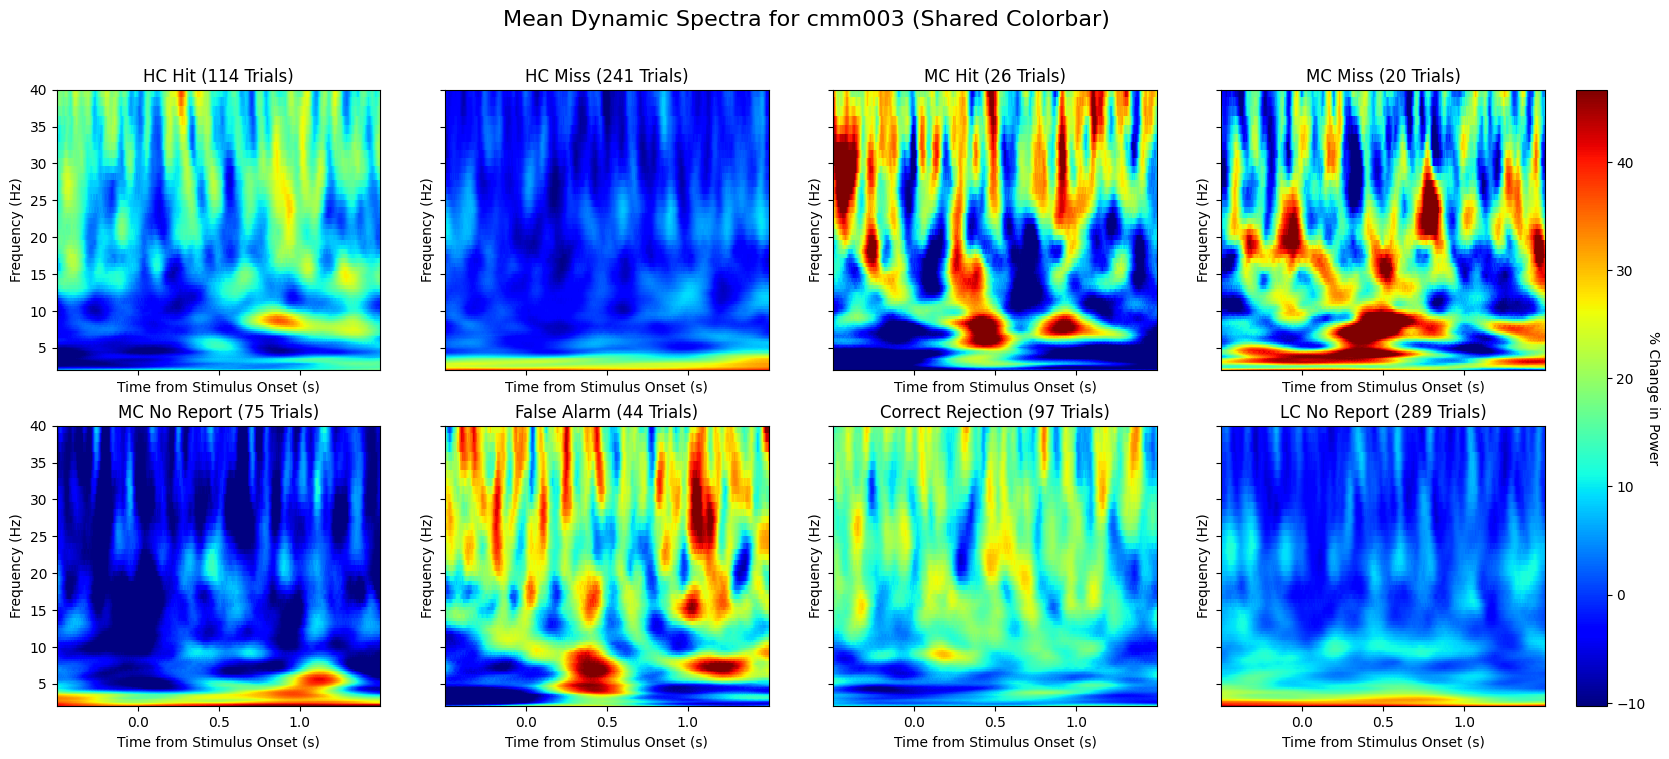

In [30]:
mouse_name = 'cmm003'
filename = "results/cmm003_dynamic_spec_denoised.h5"

plot_ds_global_norm(filename, mouse_name)
plot_shared_colorbar(filename, mouse_name)

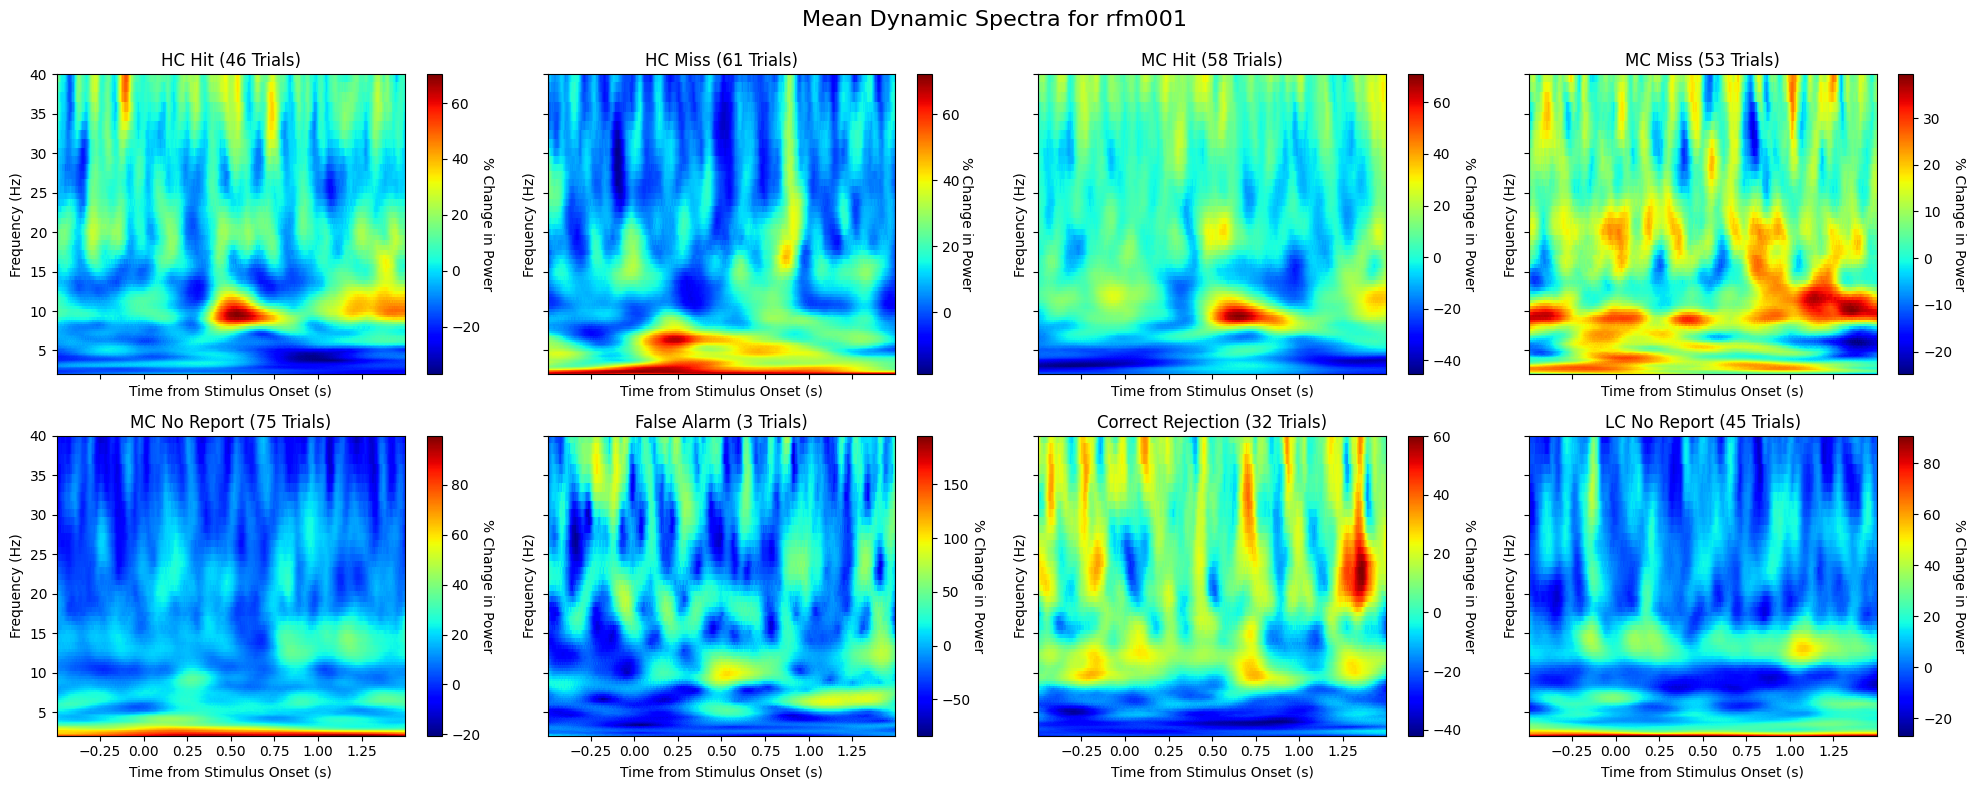

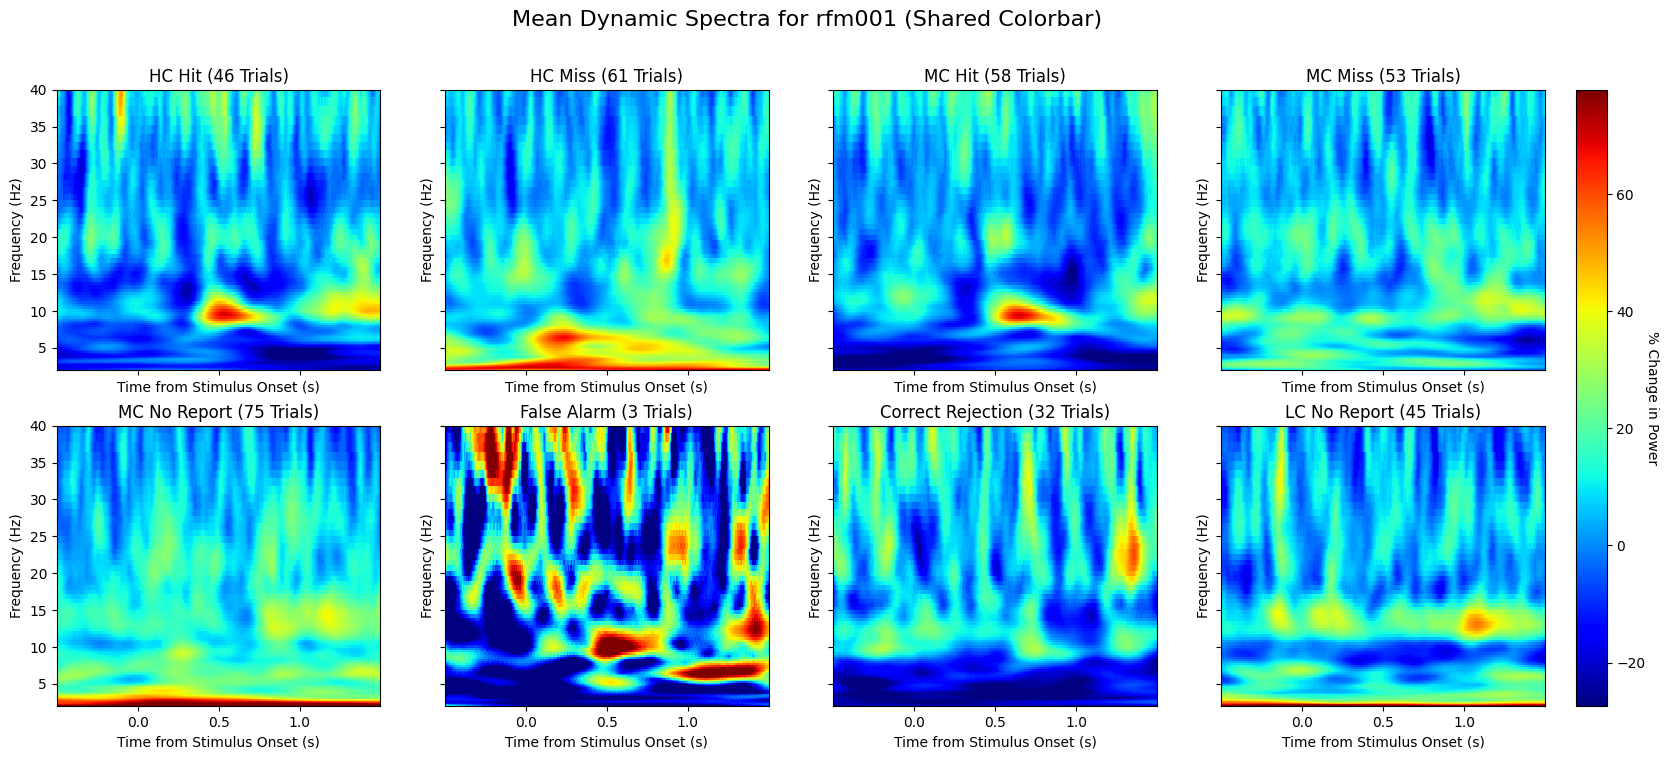

In [32]:
mouse_name = 'rfm001'
filename = f'results/{mouse_name}_dynamic_spec_denoised.h5'

plot_ds_global_norm(filename, mouse_name)
plot_shared_colorbar(filename, mouse_name)